In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Hi, Since my model is not working fine. Kindly anyone tell me comment section, how can I improve my model?
# Thanks you for visiting!!!

In [2]:
# Import 
import torch
import os
import random
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import statistics

In [3]:
# Defining the folder
colour_img = "/kaggle/input/landscape-image-colorization/landscape Images/color"
gray_img = "/kaggle/input/landscape-image-colorization/landscape Images/gray"

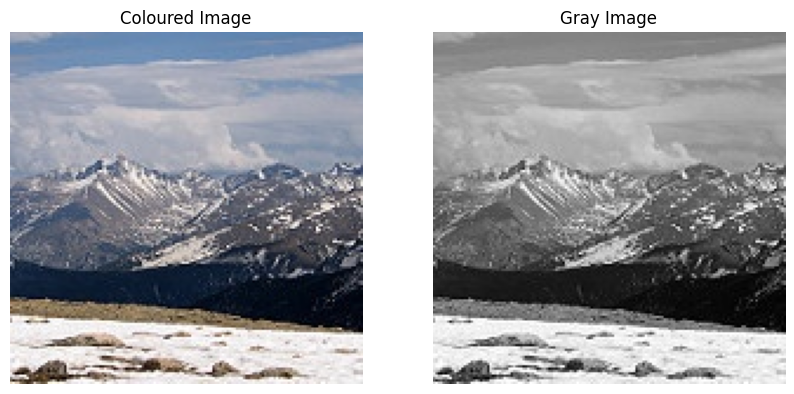

In [4]:
# Selecting the random image and viewing it
random_img = random.choice(os.listdir(colour_img))
random_colour_img = colour_img + '/' + random_img
random_gray_img = gray_img + '/' + random_img

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

image1 = plt.imread(random_colour_img)
ax[0].imshow(image1)
ax[0].set_title('Coloured Image')
ax[0].axis('off')

image2 = plt.imread(random_gray_img)
ax[1].imshow(image2, cmap='gray')
ax[1].set_title('Gray Image')
ax[1].axis('off')

plt.show()


In [5]:
# Defining the size of the picture 
SIZE = 128

In [6]:

from torch.utils.data import Dataset
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, color_dir, gray_dir, transform=None):
        self.color_dir = color_dir
        self.gray_dir = gray_dir
        self.color_images = sorted([f for f in os.listdir(color_dir) if f.endswith(('jpg', 'png', 'jpeg'))])
        self.gray_images = sorted([f for f in os.listdir(gray_dir) if f.endswith(('jpg', 'png', 'jpeg'))])
        self.transform = transform

    def __len__(self):
        # Return the length based on the directory with the fewest images
        return min(len(self.color_images), len(self.gray_images))

    def __getitem__(self, idx):
        color_img_path = os.path.join(self.color_dir, self.color_images[idx])
        gray_img_path = os.path.join(self.gray_dir, self.gray_images[idx])

        color_image = Image.open(color_img_path).convert("RGB")
        gray_image = Image.open(gray_img_path).convert("RGB")

        if self.transform:
            color_image = self.transform(color_image)
            gray_image = self.transform(gray_image)

        return color_image, gray_image

# Usage Example
color_dir = '/kaggle/input/landscape-image-colorization/landscape Images/color'
gray_dir = '/kaggle/input/landscape-image-colorization/landscape Images/gray'

transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Removing this code, this code was making image very different than original
])

dataset = CustomImageDataset(color_dir=color_dir, gray_dir=gray_dir, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

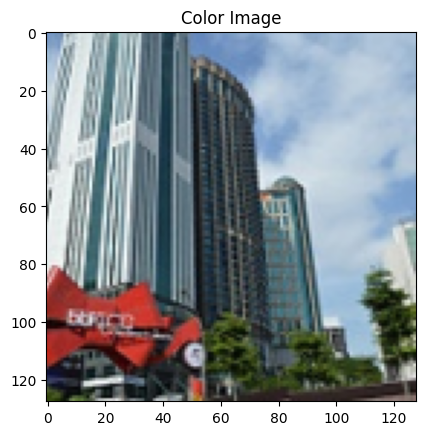

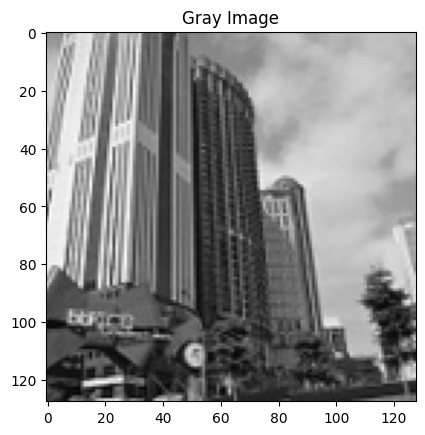

In [7]:
# Access the first pair of images (color and gray)
rand = random.randint(0,7128)
color_image, gray_image = dataset[rand]

# Convert the tensor from (C, H, W) to (H, W, C) for visualization
color_image_np = color_image.permute(1, 2, 0).numpy()
gray_image_np = gray_image.permute(1, 2, 0).numpy()

# Visualize the color image
plt.imshow(color_image_np)
plt.title("Color Image")
#plt.axis('off')
plt.show()

# Visualize the gray image
plt.imshow(gray_image_np)
plt.title("Gray Image")
#plt.axis('off')
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def createTheModel():
    class CNNAutoencoder(nn.Module):
        def __init__(self):
            super().__init__()
            
            # Encoder
            self.encoder = nn.Sequential(
                nn.Conv2d(3, SIZE, kernel_size=1, stride=1),
                nn.BatchNorm2d(SIZE),
                nn.LeakyReLU(0.2),
                nn.Conv2d(SIZE, 64, kernel_size=1, stride=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2),
                nn.Conv2d(64, 128, kernel_size=1, stride=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2),
                nn.Conv2d(128, 256, kernel_size=1, stride=1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2),
                nn.Conv2d(256, 512, kernel_size=1, stride=1),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2)
            )
            
            # Decoder
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=1, stride=1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2),
                nn.ConvTranspose2d(256, 128, kernel_size=1, stride=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2),
                nn.ConvTranspose2d(128, 64, kernel_size=1, stride=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2),
                nn.ConvTranspose2d(64, SIZE, kernel_size=1, stride=1),
                nn.BatchNorm2d(SIZE),
                nn.LeakyReLU(0.2),
                nn.ConvTranspose2d(SIZE, 3, kernel_size=1, stride=1),
                nn.BatchNorm2d(3)
            )

        def forward(self, x):
            x = self.encoder(x)
            x = self.decoder(x)
            return x

    # Create the model instance
    net = CNNAutoencoder()
    
    # Loss function
    lossfun = nn.MSELoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
    return net, lossfun, optimizer

In [9]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# best model till now
# def createTheModel():
#     class CNNAutoencoder(nn.Module):
#         def __init__(self):
#             super().__init__()
            
#             # Encoder
#             self.encoder = nn.Sequential(
#                 nn.Conv2d(3, SIZE, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(SIZE),
#                 nn.ReLU(),
#                 nn.Conv2d(SIZE, 64, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(),
#                 nn.Conv2d(64, 128, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(128),
#                 nn.ReLU(),
#                 nn.Conv2d(128, 256, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(256),
#                 nn.ReLU(),
#                 nn.Conv2d(256, 512, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(512),
#                 nn.ReLU()
#             )
            
#             # Decoder
#             self.decoder = nn.Sequential(
#                 nn.ConvTranspose2d(512, 256, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(256),
#                 nn.ReLU(),
#                 nn.ConvTranspose2d(256, 128, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(128),
#                 nn.ReLU(),
#                 nn.ConvTranspose2d(128, 64, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(),
#                 nn.ConvTranspose2d(64, SIZE, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(SIZE),
#                 nn.ReLU(),
#                 nn.ConvTranspose2d(SIZE, 3, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(3),
#                 nn.Sigmoid()
#             )

#         def forward(self, x):
#             x = self.encoder(x)
#             x = self.decoder(x)
#             return x

#     # Create the model instance
#     net = CNNAutoencoder()
    
#     # Loss function
#     lossfun = nn.MSELoss()
    
#     # Optimizer
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
#     return net, lossfun, optimizer

In [10]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# def createTheModel():
#     class CNNAutoencoder(nn.Module):
#         def __init__(self):
#             super().__init__()
            
#             # Encoder
#             self.encoder = nn.Sequential(
#                 nn.Conv2d(3, SIZE, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(SIZE),
#                 nn.Conv2d(SIZE, 64, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(64),
#                 nn.Conv2d(64, 128, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(128),
#                 nn.Conv2d(128, 256, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(256),
#                 nn.Conv2d(256, 512, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(512)
#             )
            
#             # Decoder
#             self.decoder = nn.Sequential(
#                 nn.ConvTranspose2d(512, 256, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(256),
#                 nn.ConvTranspose2d(256, 128, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(128),
#                 nn.ConvTranspose2d(128, 64, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(64),
#                 nn.ConvTranspose2d(64, SIZE, kernel_size=1, stride=1),
#                 nn.BatchNorm2d(SIZE),
#                 nn.ConvTranspose2d(SIZE, 3, kernel_size=1, stride=1),
                
#             )

#         def forward(self, x):
#             x = self.encoder(x)
#             x = self.decoder(x)
#             return x

#     # Create the model instance
#     net = CNNAutoencoder()
    
#     # Loss function
#     lossfun = nn.MSELoss()
    
#     # Optimizer
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    
#     return net, lossfun, optimizer

In [11]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# def createTheModel(SIZE):
#     class CNNAutoencoder(nn.Module):
#         def __init__(self):
#             super().__init__()
            
#             # Encoder
#             self.encoder = nn.Sequential(
#                 nn.Conv2d(3, SIZE, kernel_size=1, stride=1, padding=0),
#                 nn.BatchNorm2d(SIZE),
#                 nn.ReLU(),
#                 nn.Conv2d(SIZE, 64, kernel_size=1, stride=1, padding=0),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(),
#                 nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0),
#                 nn.BatchNorm2d(128),
#                 nn.ReLU(),
#                 nn.Flatten(),
#                 nn.Linear(128 * SIZE * SIZE, 500)
#             )
            
#             # Latent space
#             self.fc1 = nn.Linear(500, 2500)
#             self.fc2 = nn.Linear(2500, 500)
            
#             # Decoder
#             self.decoder = nn.Sequential(
#                 nn.Linear(500, 128 * SIZE * SIZE),
#                 nn.ReLU(),
#                 nn.Unflatten(1, (128, SIZE, SIZE)),
#                 nn.ConvTranspose2d(128, 64, kernel_size=1, stride=1, padding=0),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(),
#                 nn.ConvTranspose2d(64, SIZE, kernel_size=1, stride=1, padding=0),
#                 nn.BatchNorm2d(SIZE),
#                 nn.ReLU(),
#                 nn.ConvTranspose2d(SIZE, 3, kernel_size=1, stride=1, padding=0),
#                 nn.Sigmoid()
#             )

#         def forward(self, x):
#             x = self.encoder(x)
#             x = F.relu(self.fc1(x))
#             x = F.relu(self.fc2(x))
#             x = self.decoder(x)
#             return x

#     # Create the model instance
#     net = CNNAutoencoder()
    
#     # Loss function
#     lossfun = nn.MSELoss()
    
#     # Optimizer
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
#     return net, lossfun, optimizer

In [12]:
# Generate a random tensor with the specified size
net,lossfun,optimizer = createTheModel()
X = torch.randn( 1, 3 , SIZE , SIZE )
yHat = net(X)
yHat.shape

torch.Size([1, 3, 128, 128])

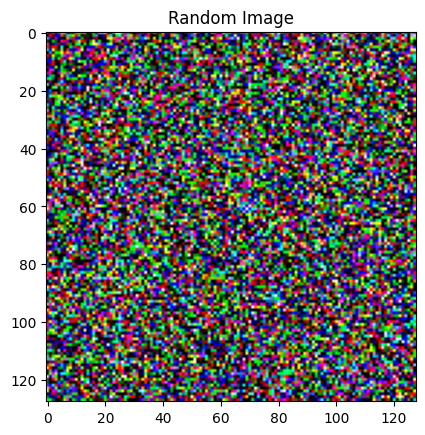

In [13]:
# Visualizing the randomly generated image
X = X.squeeze()
X_RI = X.permute(1, 2, 0).numpy()
plt.title("Random Image")
plt.imshow(X_RI)
plt.show()

In [14]:
yHat.shape

torch.Size([1, 3, 128, 128])

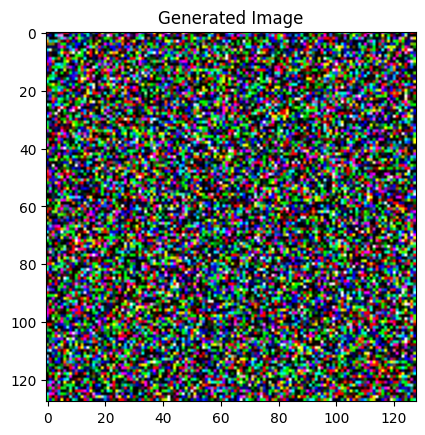

In [15]:
# Visualizing the output from the neural network
yHat = yHat.squeeze(0)
yHat_pic = yHat.permute(1, 2, 0).detach().numpy()
plt.title("Generated Image")
plt.imshow(yHat_pic)
plt.show()


In [16]:
random_num = random.randint(1,7129)
color_image, gray_image = dataset[random_num]
print(color_image.shape,gray_image.shape)

torch.Size([3, 128, 128]) torch.Size([3, 128, 128])


In [17]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

def function2trainTheModel(dataset, num_epochs=3, batch_size=32):
    net, lossfun, optimizer = createTheModel()
    
    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            sampler=SubsetRandomSampler(range(len(dataset))),
                            num_workers=4, pin_memory=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    losses = []
    print("Model Training Started!")
    for epoch in range(num_epochs):
        epoch_losses = []
        
        for color_images, gray_images in dataloader:
            color_images = color_images.to(device)
            gray_images = gray_images.to(device)
            
            optimizer.zero_grad()
            outputs = net(gray_images)
            loss = lossfun(outputs, color_images)
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        print(f"Epoch: {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")
    print("Model Training Finished!")
    return losses, net


In [18]:
losses,net = function2trainTheModel(dataset)

Model Training Started!
Epoch: 1/3 | Loss: 0.5492
Epoch: 2/3 | Loss: 0.2482
Epoch: 3/3 | Loss: 0.1053
Model Training Finished!


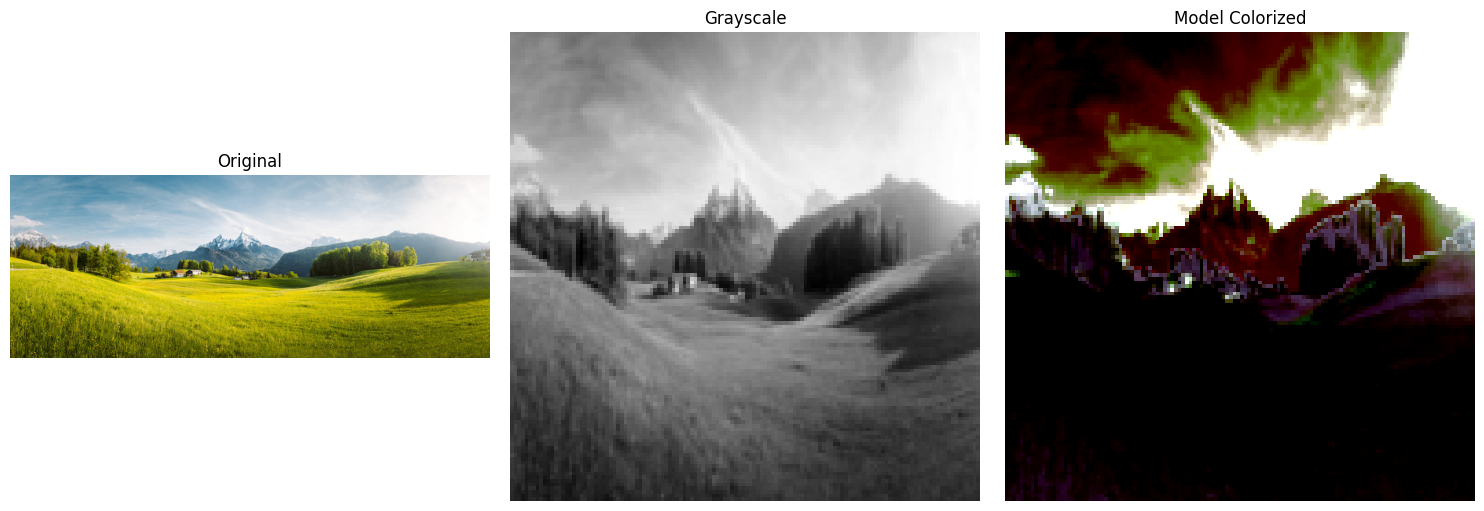

In [19]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

def test_model_on_url(net, image_url, size=SIZE):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Ensure the model is on the correct device
    net.to(device)
    
    # Download the image
    response = requests.get(image_url)
    original_img = Image.open(BytesIO(response.content)).convert('RGB')
    
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(original_img).unsqueeze(0)  # Add batch dimension
    
    # Move the input tensor to the same device as the model
    img_tensor = img_tensor.to(device)
    
    # Pass through the model
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        colorized_output = net(img_tensor)
    
    # Move the output back to CPU for visualization
    colorized_output = colorized_output.cpu()
    
    # Reshape the output
    colorized_image = colorized_output.squeeze(0)  # Remove batch dimension
    
    # Display results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.imshow(original_img)
    ax1.set_title('Original')
    ax1.axis('off')
    
    ax2.imshow(img_tensor.squeeze(0).permute(1, 2, 0).mean(dim=2).cpu(), cmap='gray')
    ax2.set_title('Grayscale')
    ax2.axis('off')
    
    ax3.imshow(colorized_image.permute(1, 2, 0).clamp(0, 1))
    ax3.set_title('Model Colorized')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

image_url = "https://t3.ftcdn.net/jpg/03/15/34/90/360_F_315349043_6ohfFyx37AFusCKZtGQtJR0jqUxhb25Y.jpg"

# Test the model
test_model_on_url(net, image_url)


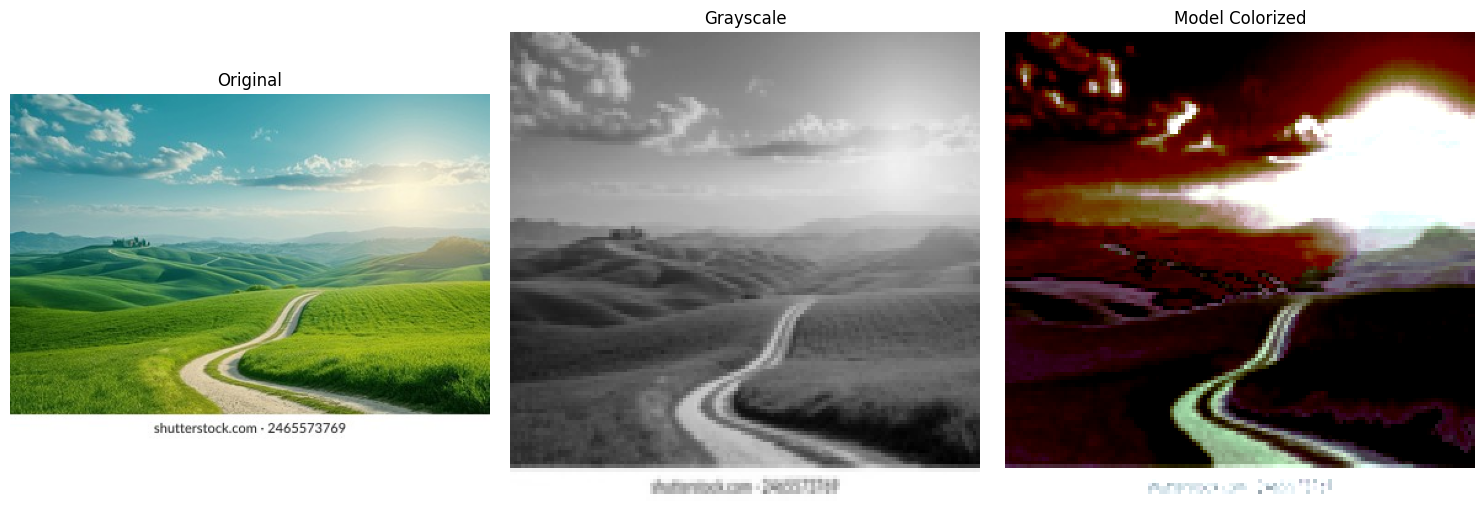

In [20]:
image_url = "https://www.shutterstock.com/image-photo/landscape-road-mountains-260nw-2465573769.jpg"
test_model_on_url(net, image_url)

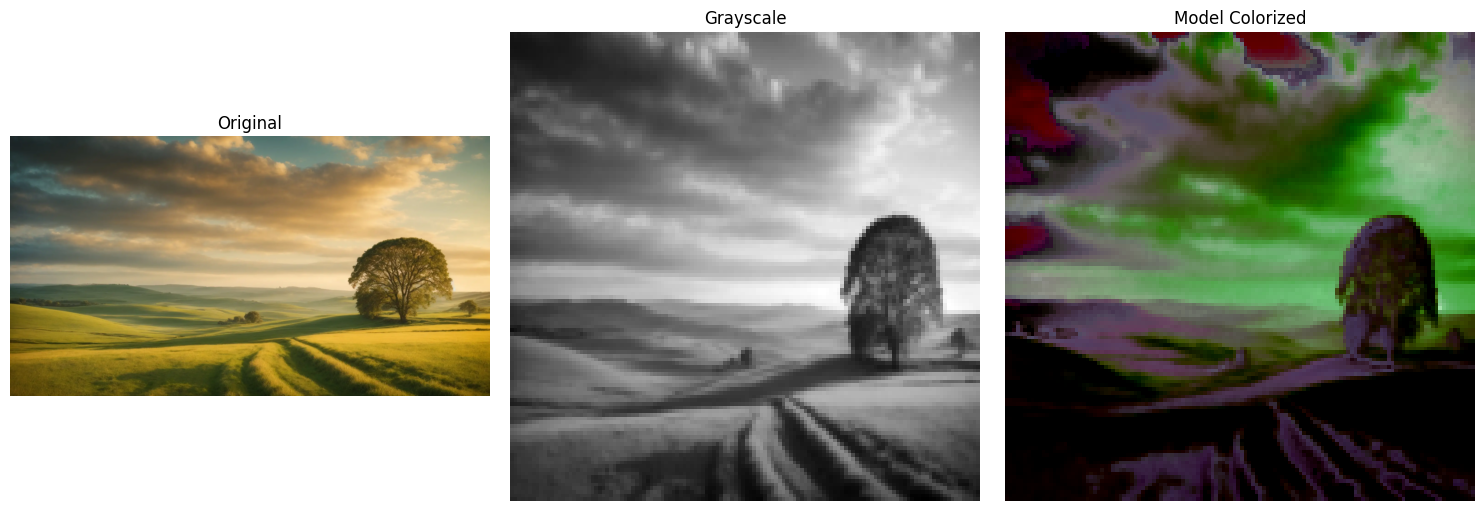

In [21]:
image_url = "https://cdn.prod.website-files.com/63a02e61e7ffb565c30bcfc7/65ea99845e53084280471b71_most%20beautiful%20landscapes%20in%20the%20world.webp"
test_model_on_url(net, image_url)